In [1]:
library(dplyr)
library(Seurat)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject



In [2]:
library(ggplot2)
library(cowplot)


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




In [3]:
library("clustree")

Loading required package: ggraph



In [4]:

## remove the x-axis text and tick
## plot.margin to adjust the white space between each plot.
## ... pass any arguments to VlnPlot in Seurat
modify_vlnplot<- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_text(size = rel(1), angle = 0), 
          axis.text.y = element_text(size = rel(1)), 
          plot.margin = plot.margin ) 
  return(p)
}

## extract the max value of the y axis
extract_max<- function(p){
  ymax<- max(ggplot_build(p)$layout$panel_scales_y[[1]]$range$range)
  return(ceiling(ymax))
}


## main function
StackedVlnPlot<- function(obj, features,
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  
  plot_list<- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  
  # Add back x-axis title to bottom plot. patchwork is going to support this?
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(), axis.ticks.x = element_line())
  
  # change the y-axis tick to only max value 
  ymaxs<- purrr::map_dbl(plot_list, extract_max)
  plot_list<- purrr::map2(plot_list, ymaxs, function(x,y) x + 
                            scale_y_continuous(breaks = c(y)) + 
                            expand_limits(y = y))

  p<- patchwork::wrap_plots(plotlist = plot_list, ncol = 1)
  return(p)
}

In [5]:
normal.data <- Read10X(data.dir = "./filtered_feature_pAL_PC_3")
normal <- CreateSeuratObject(counts = normal.data, project = "pALPC3", min.cells = 3, min.features = 100)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [6]:
normal

An object of class Seurat 
15640 features across 5799 samples within 1 assay 
Active assay: RNA (15640 features, 0 variable features)

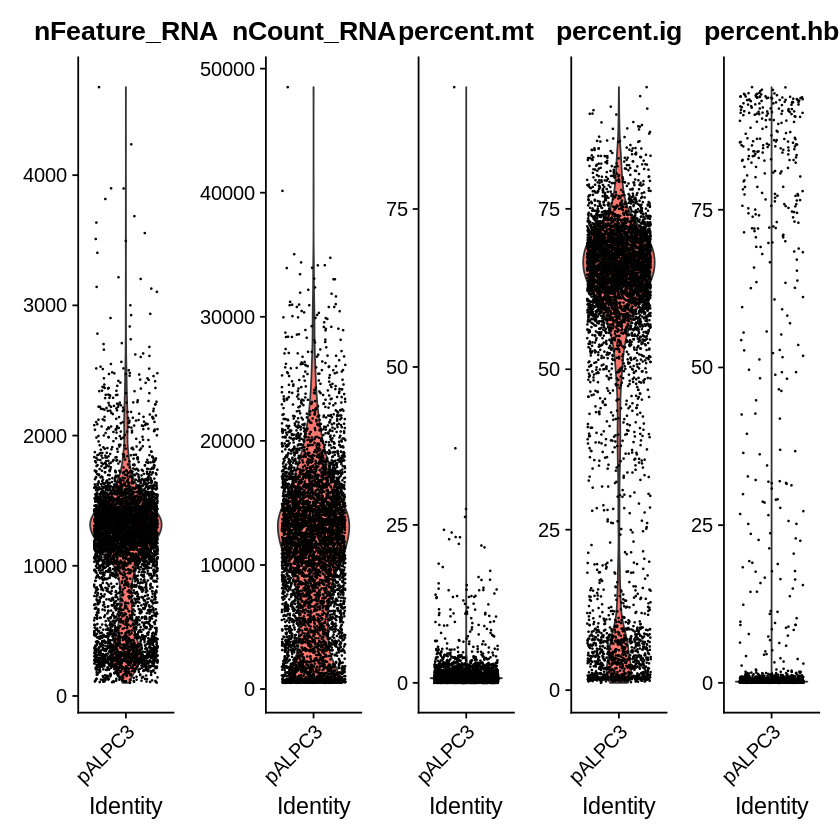

In [7]:
normal[["percent.mt"]] <- PercentageFeatureSet(normal, pattern = "^MT-")
normal[["percent.ig"]] <- PercentageFeatureSet(normal, pattern = "^IG")
normal[["percent.hb"]] <- PercentageFeatureSet(normal, pattern = "^HB")
VlnPlot(normal, features = c("nFeature_RNA", "nCount_RNA", "percent.mt","percent.ig","percent.hb"), ncol = 5)

In [8]:
summary(normal@meta.data)

  orig.ident     nCount_RNA     nFeature_RNA    percent.mt     
 pALPC3:5799   Min.   :  499   Min.   : 101   Min.   : 0.0000  
               1st Qu.: 6036   1st Qu.: 803   1st Qu.: 0.5656  
               Median :11683   Median :1231   Median : 0.7628  
               Mean   :11002   Mean   :1120   Mean   : 1.1141  
               3rd Qu.:15044   3rd Qu.:1408   3rd Qu.: 1.0479  
               Max.   :48507   Max.   :4676   Max.   :94.2867  
   percent.ig       percent.hb     
 Min.   : 1.143   Min.   : 0.0000  
 1st Qu.:55.167   1st Qu.: 0.1074  
 Median :64.118   Median : 0.1380  
 Mean   :54.794   Mean   : 4.2670  
 3rd Qu.:68.888   3rd Qu.: 0.1978  
 Max.   :93.955   Max.   :94.4404  

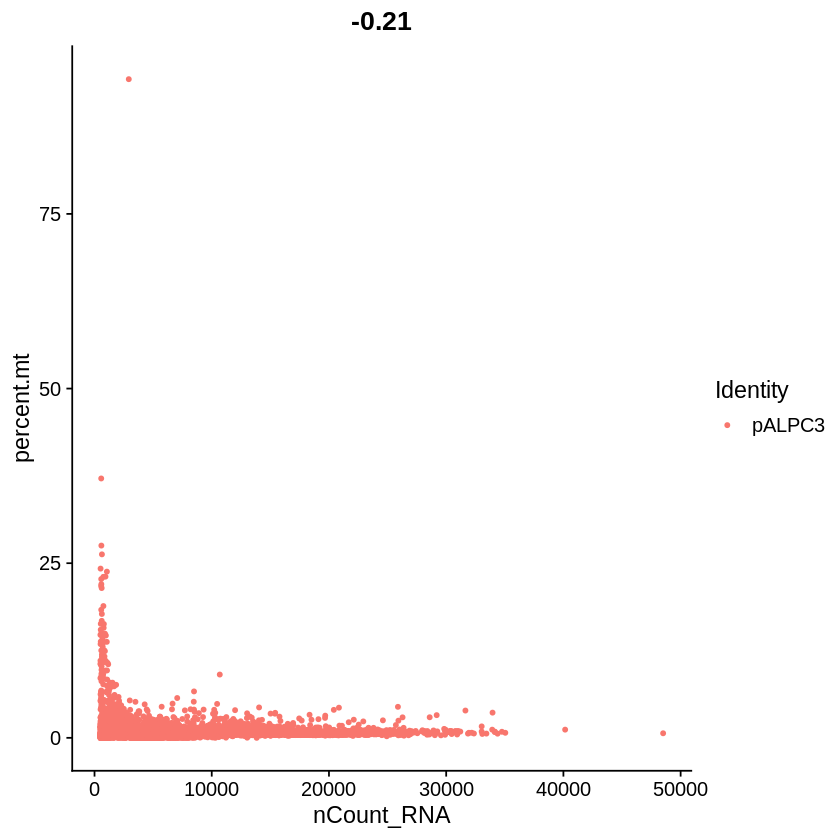

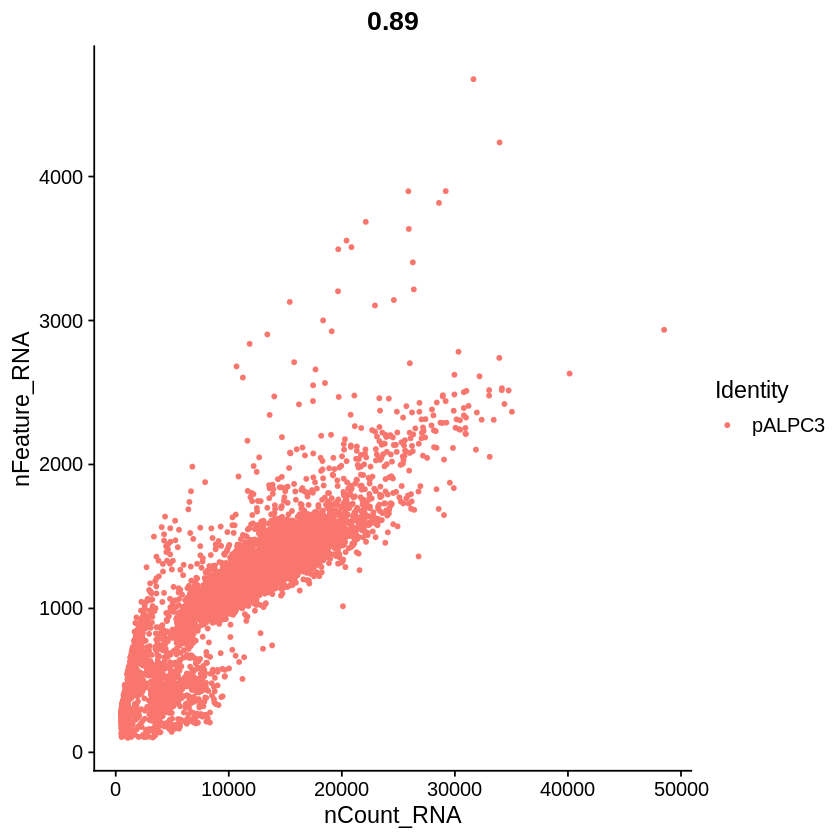

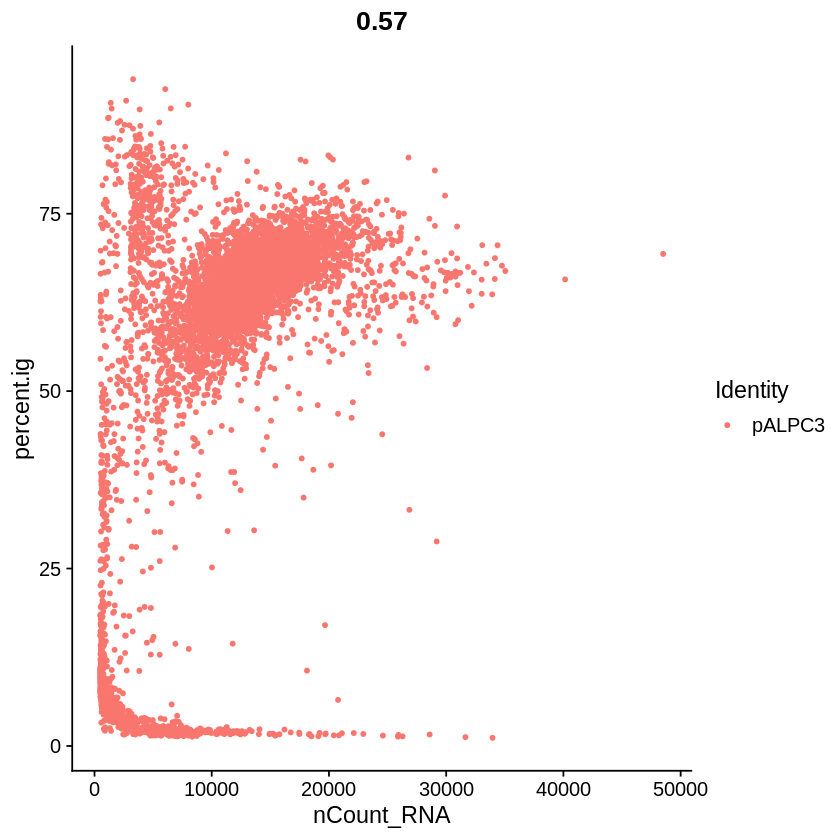

In [9]:
plot1 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot3 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.ig")
plot1
plot2
plot3

In [10]:
normal <- subset(normal, subset = nFeature_RNA > 100 & nFeature_RNA < 2500 & percent.mt < 5 & percent.hb < 1)
normal

An object of class Seurat 
15640 features across 5247 samples within 1 assay 
Active assay: RNA (15640 features, 0 variable features)

In [11]:
normal <- NormalizeData(normal, normalization.method = "LogNormalize", scale.factor = 10000)

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 50 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 50 rows containing missing values (geom_point).”


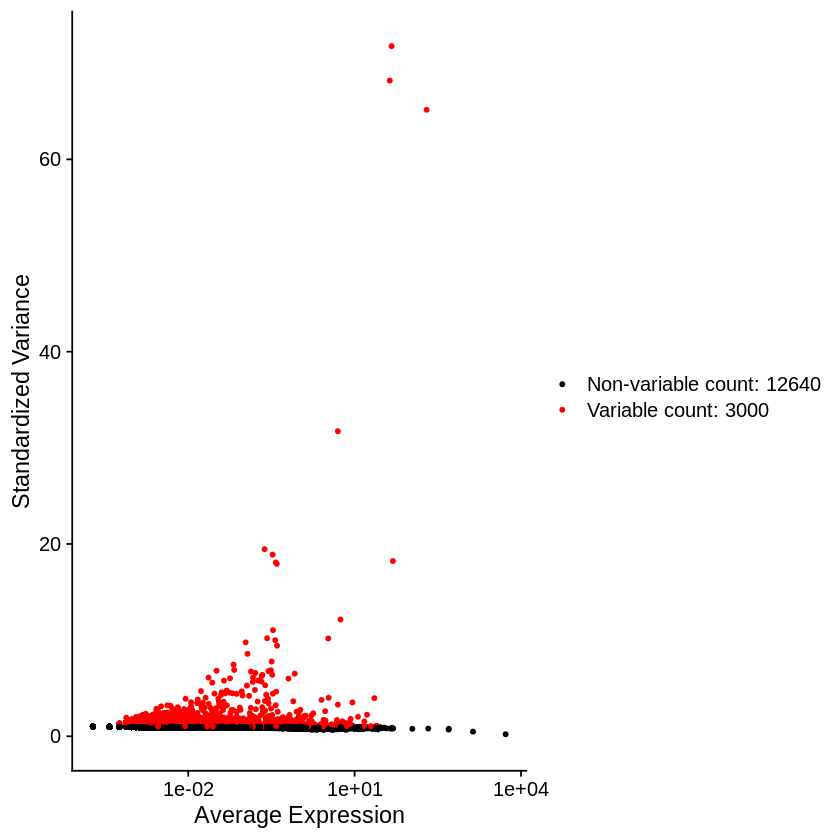

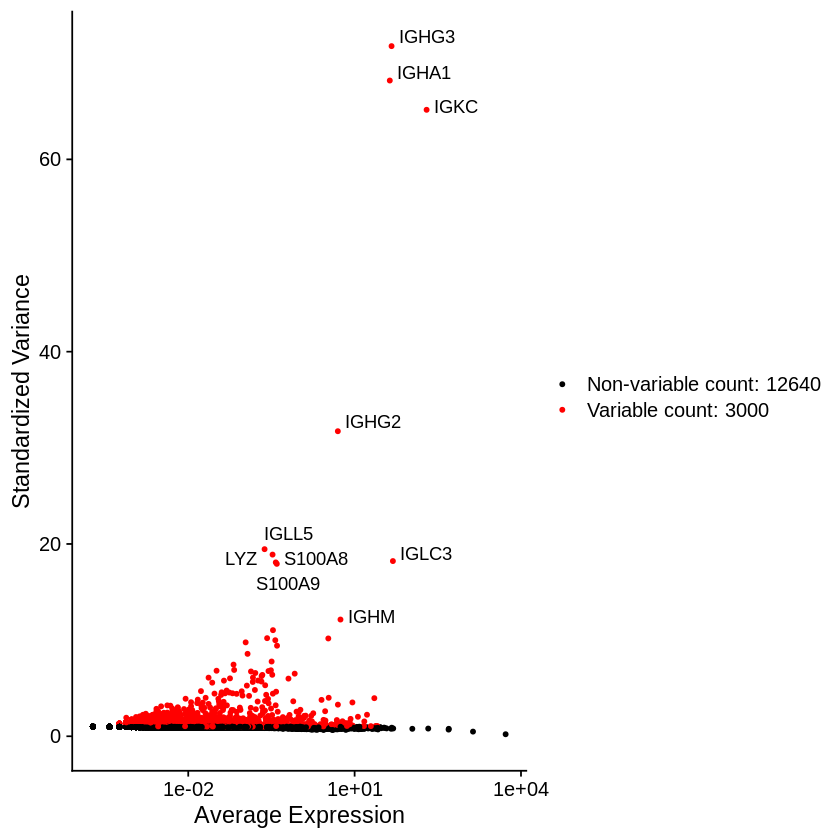

In [12]:
normal <- FindVariableFeatures(normal, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1
plot2

In [13]:
all.genes <- rownames(normal)
normal <- ScaleData(normal, features = all.genes)

Centering and scaling data matrix



In [14]:
length(VariableFeatures(object = normal))

[1] 3000

In [15]:
normal <- RunPCA(normal, features = VariableFeatures(object = normal))

PC_ 1 
Positive:  TMSB4X, TYROBP, ACTB, HLA-DPB1, HLA-DRB1, S100A11, S100A4, HLA-DPA1, FTH1, AIF1 
	   FTL, HLA-DRA, ITGB2, HCST, CST3, CD52, FCER1G, LST1, SH3BGRL3, IFITM2 
	   GIMAP4, ARHGDIB, SAT1, IFITM3, CORO1A, BLVRB, ANXA1, ARPC1B, GIMAP7, COTL1 
Negative:  MZB1, FKBP11, IGLC3, CCND1, HSP90B1, HERPUD1, XBP1, RP5-887A10.1, SEC11C, FRZB 
	   JUN, MYDGF, DERL3, PRDX4, MTDH, COMMD3, PDIA4, SELK, FOSB, ERLEC1 
	   TXNDC5, ISG20, CRELD2, FAM46C, TSC22D3, HSPA5, MDK, SDF2L1, IGHM, TNFRSF13B 
PC_ 2 
Positive:  APOC1, BLVRB, SEPP1, HMOX1, FTL, AIF1, FABP5, C1QB, APOE, C1QA 
	   GLUL, C1QC, GPX1, MS4A7, FABP4, FABP3, SAT1, FTH1, TUBA1B, CD5L 
	   SDCBP, CST3, STMN1, HNMT, DAB2, MS4A6A, LST1, VCAM1, SLC40A1, OTOA 
Negative:  HLA-C, HLA-A, NKG7, MT-CO1, CCL5, HLA-B, GZMA, MT-CYB, IL32, MT-ND2 
	   CST7, KLRD1, MT-ND1, PRF1, CMC1, BTG1, GZMH, CD2, S100A4, CORO1A 
	   TRDC, KLRF1, HCST, CD247, CD7, RPL3, LCK, PTPRC, CTSW, CCL4 
PC_ 3 
Positive:  FCN1, LYZ, MNDA, CSTA, FGL2, S100A8, S100A9, SE

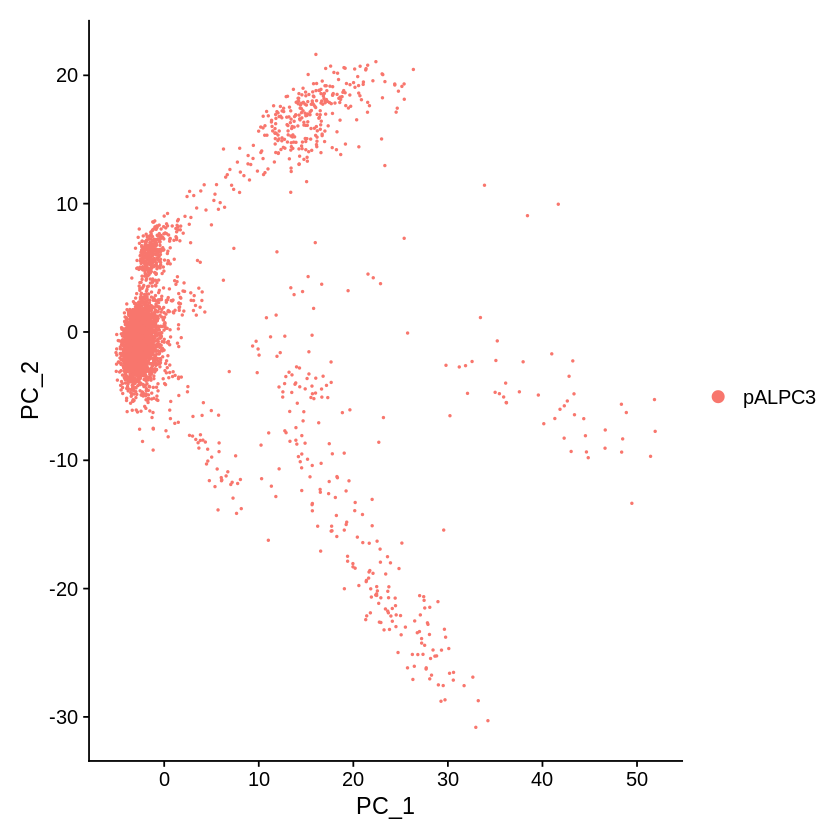

In [16]:
DimPlot(normal, reduction = "pca")

In [17]:
normal <- JackStraw(normal, num.replicate = 100)
normal <- ScoreJackStraw(normal, dims = 1:20)

Warning message:
“Removed 42086 rows containing missing values (geom_point).”


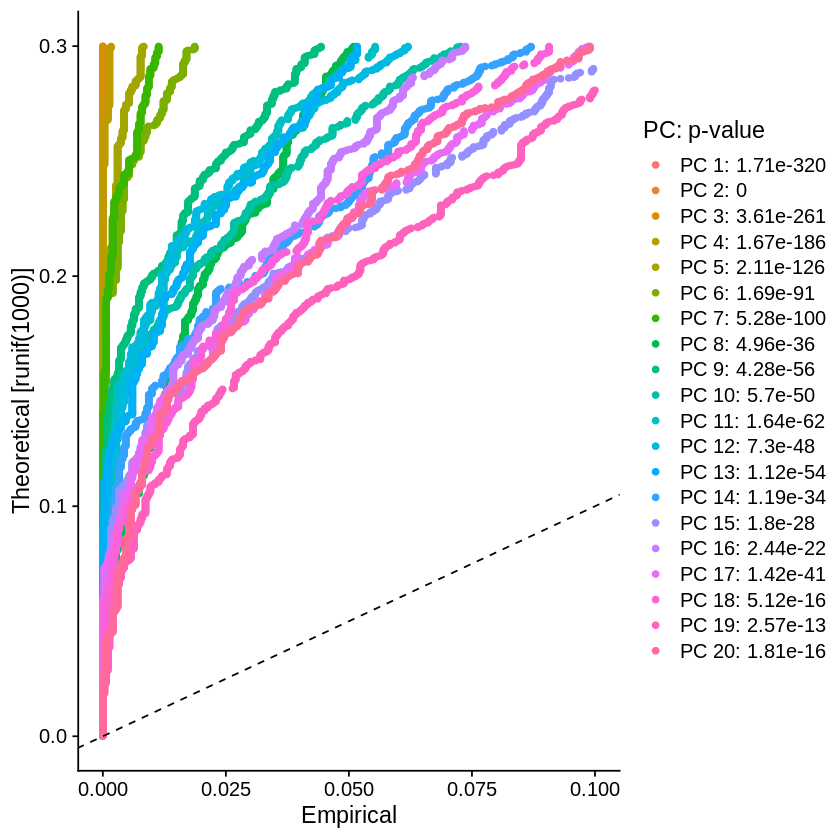

In [18]:
JackStrawPlot(normal, dims = 1:20)

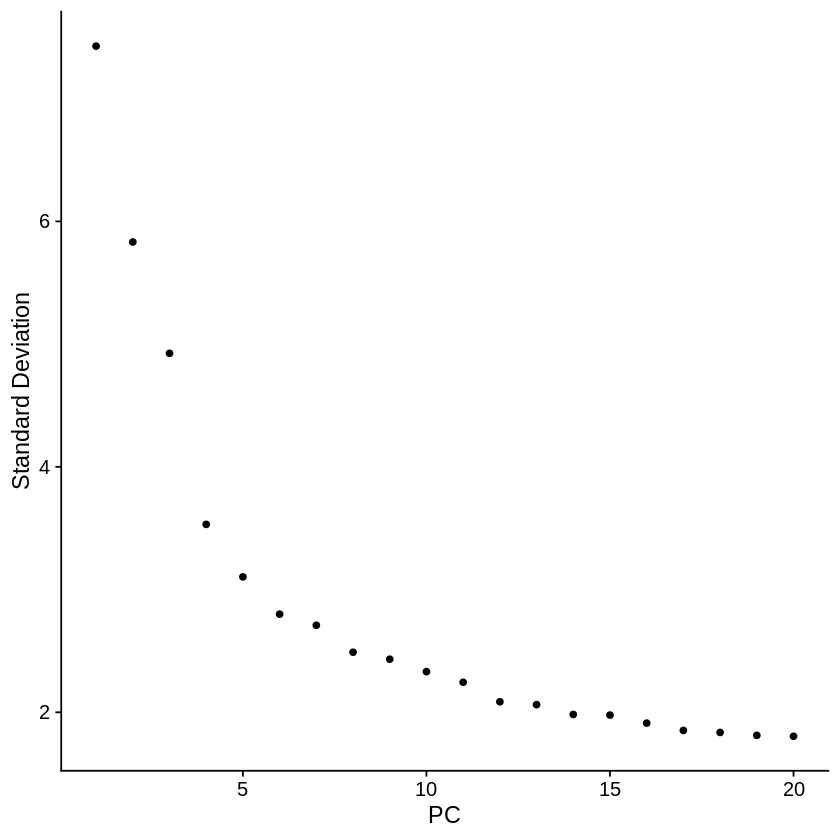

In [19]:
ElbowPlot(normal)

In [20]:
normal <- RunUMAP(normal, dims = 1:8)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
12:46:58 UMAP embedding parameters a = 0.9922 b = 1.112

12:46:58 Read 5247 rows and found 8 numeric columns

12:46:58 Using Annoy for neighbor search, n_neighbors = 30

12:46:58 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:46:59 Writing NN index file to temp file /tmp/RtmpYXGwus/file826da12b850a0

12:46:59 Searching Annoy index using 1 thread, search_k = 3000

12:47:00 Annoy recall = 100%

12:47:00 Commencing smooth kNN distance calibration using 1 thread

12:47:01 Initializing fro

In [21]:
options(repr.plot.height=8,repr.plot.width=8)

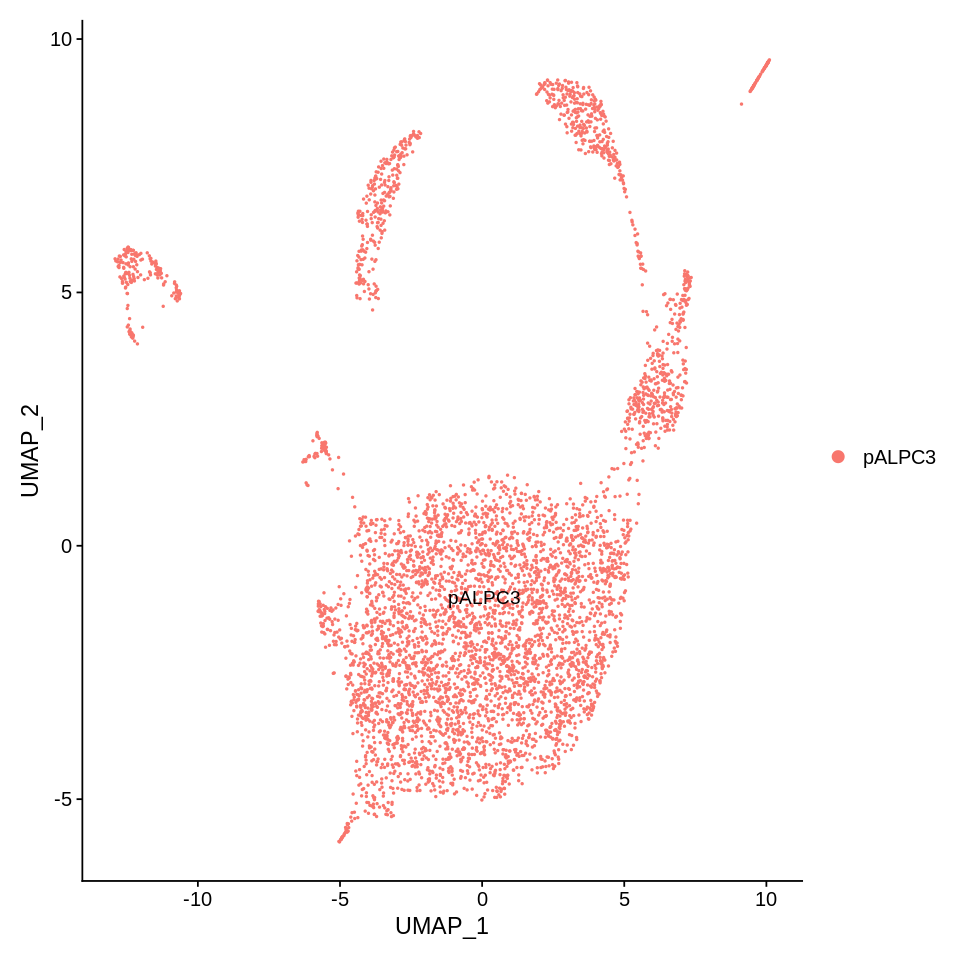

In [22]:
DimPlot(normal, reduction = "umap",label=T)

Loading required package: fields

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.7-0 (2021-06-25) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR

Loading required package: modes



NULL


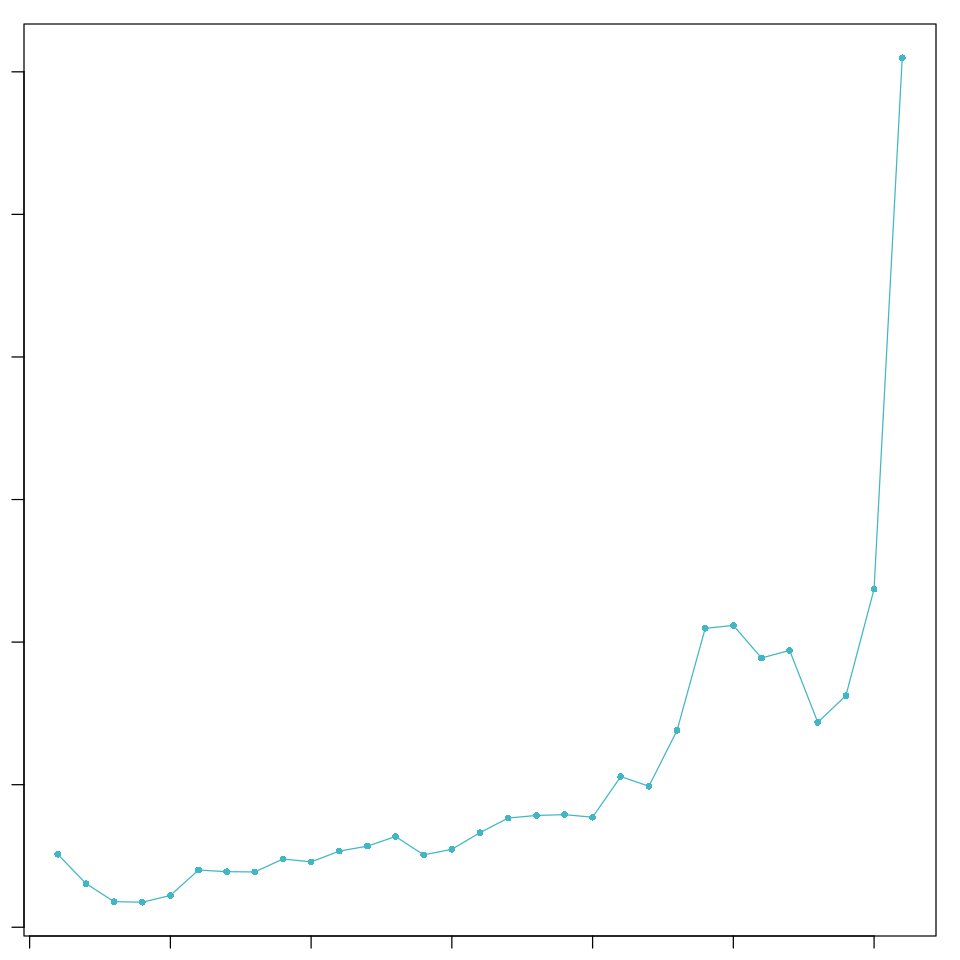

In [23]:
library(DoubletFinder)
sweep.res.list <- paramSweep_v3(normal, PCs = 1:8, sct = FALSE)
for(i in 1:length(sweep.res.list)){
  if(length(sweep.res.list[[i]]$pANN[is.nan(sweep.res.list[[i]]$pANN)]) != 0){
    if(i != 1){
      sweep.res.list[[i]] <- sweep.res.list[[i - 1]]
    }else{
      sweep.res.list[[i]] <- sweep.res.list[[i + 1]]
    }
  }
}
sweep.stats <- summarizeSweep(sweep.res.list, GT = FALSE)
bcmvn <- find.pK(sweep.stats)
pk_v <- as.numeric(as.character(bcmvn$pK))
pk_good <- pk_v[bcmvn$BCmetric==max(bcmvn$BCmetric)]
nExp_poi <- round(0.1*length(colnames(normal)))

In [24]:
normal <- doubletFinder_v3(normal, PCs = 1:8, pN = 0.25, pK = pk_good, nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)

[1] "Creating 1749 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


In [25]:
colnames(normal@meta.data)[ncol(normal@meta.data)]="DoubletFinder"

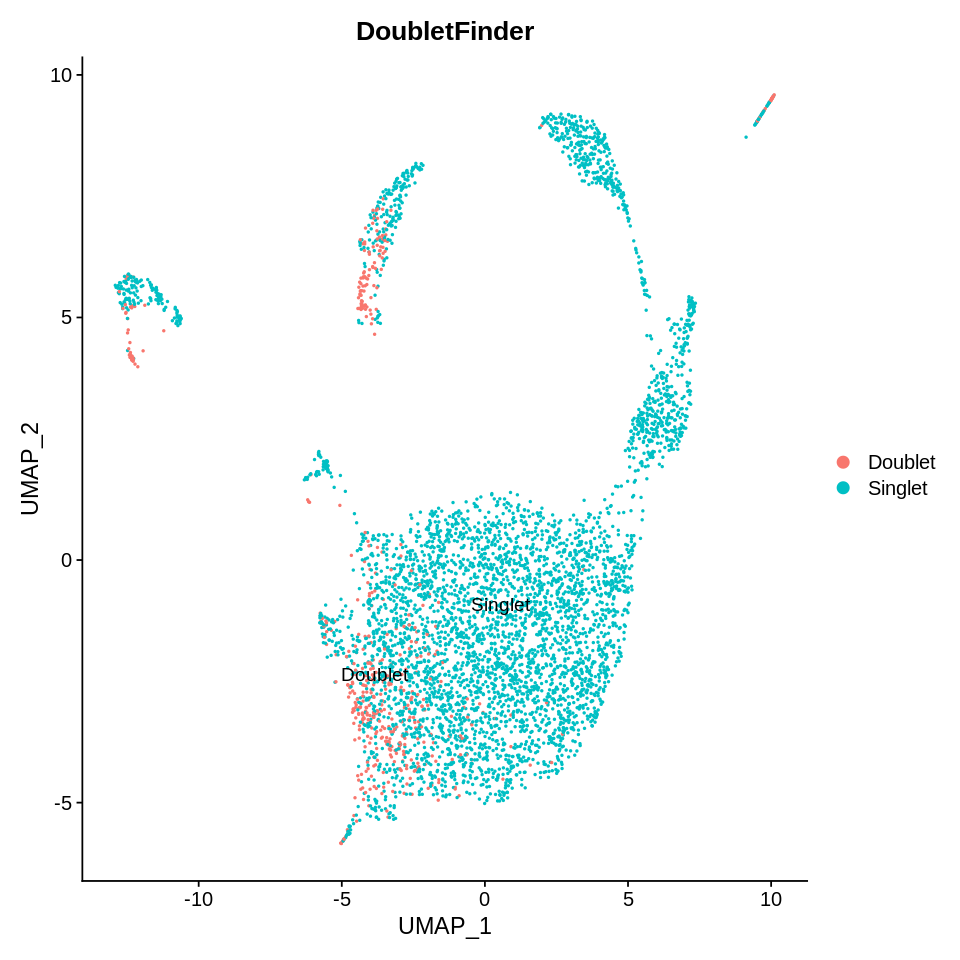

In [26]:
DimPlot(normal, reduction = "umap",label=T,group.by='DoubletFinder')

In [27]:
normal2<-subset(normal,DoubletFinder=='Singlet')

In [28]:
normal
normal2

An object of class Seurat 
15640 features across 5247 samples within 1 assay 
Active assay: RNA (15640 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
15640 features across 4722 samples within 1 assay 
Active assay: RNA (15640 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 129 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 129 rows containing missing values (geom_point).”


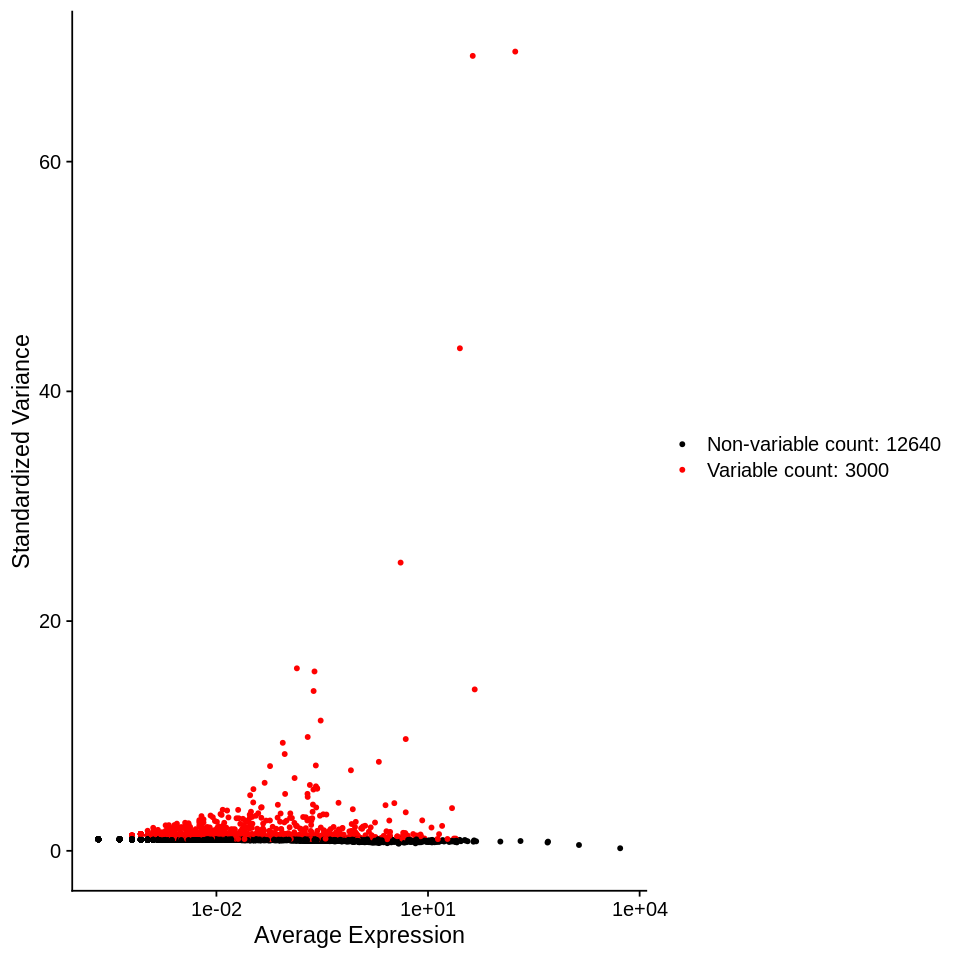

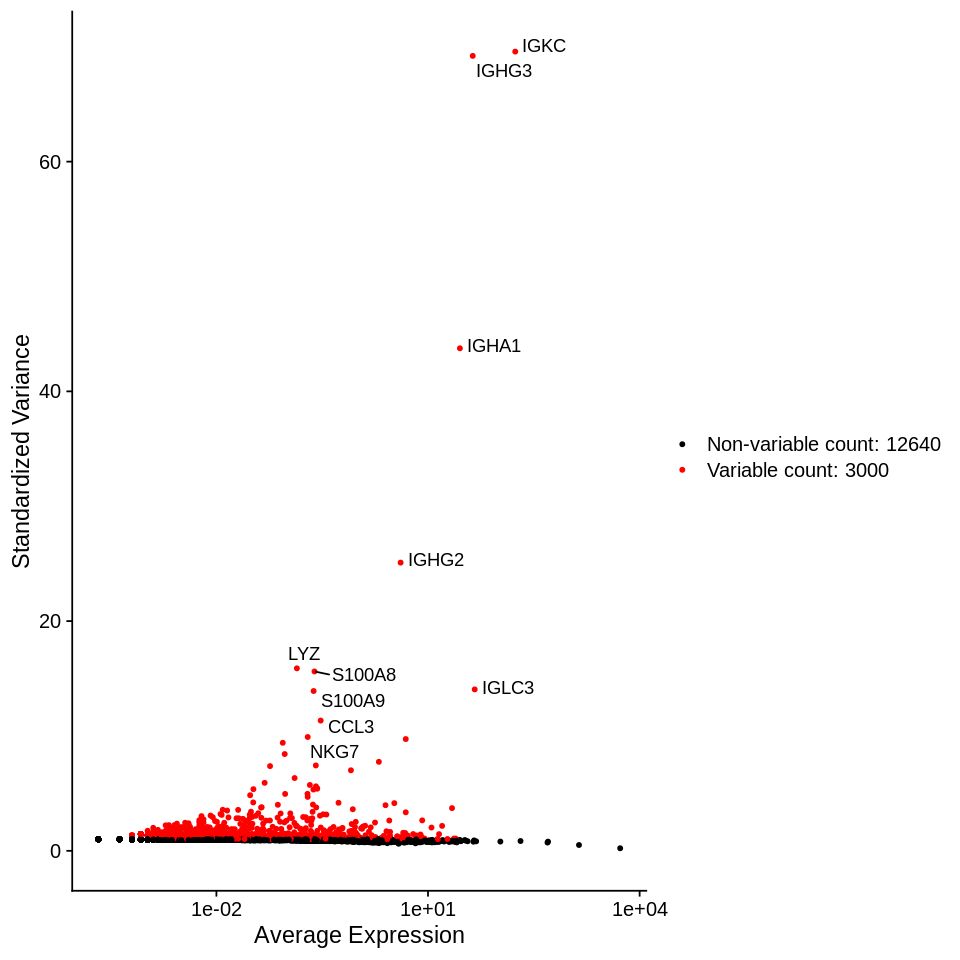

In [29]:
normal2 <- FindVariableFeatures(normal2, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal2), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal2)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1
plot2

In [30]:
all.genes <- rownames(normal2)
normal2 <- ScaleData(normal2, features = all.genes)

Centering and scaling data matrix



In [31]:
length(VariableFeatures(object = normal2))

[1] 3000

In [32]:
normal2 <- RunPCA(normal2, features = VariableFeatures(object = normal2))

PC_ 1 
Positive:  MZB1, IGLC3, FKBP11, CCND1, HSP90B1, HERPUD1, XBP1, RP5-887A10.1, JUN, FRZB 
	   SEC11C, MTDH, MYDGF, DERL3, FOSB, COMMD3, PRDX4, TSC22D3, NUCB2, DUSP1 
	   ERLEC1, ISG20, FAM46C, BTG2, HSPA5, ANKRD28, IGHM, HLA-C, TNFRSF13B, LINC01480 
Negative:  TMSB4X, FTL, TYROBP, HLA-DPB1, FTH1, ACTB, AIF1, S100A11, BLVRB, HLA-DPA1 
	   APOC1, FABP5, GLUL, HLA-DRB1, SAT1, HLA-DRA, CST3, C1QB, C1QA, APOE 
	   GPX1, SDCBP, HMOX1, LST1, C1QC, FCER1G, GIMAP4, SEPP1, MS4A7, HCST 
PC_ 2 
Positive:  BLVRB, SEPP1, APOC1, HMOX1, AIF1, C1QA, C1QB, APOE, FABP5, FTL 
	   GPX1, GLUL, C1QC, MS4A7, FABP4, FABP3, TUBA1B, SAT1, CST3, STMN1 
	   CD5L, FTH1, SDCBP, LST1, HNMT, DAB2, MS4A6A, VCAM1, SLC40A1, NGFRAP1 
Negative:  NKG7, CCL5, IL32, GZMA, CST7, KLRD1, CD2, CMC1, S100A4, GZMH 
	   PRF1, HLA-A, HLA-C, MT-CO1, HLA-B, HCST, CORO1A, TRDC, LCK, ITGB2 
	   TRAC, KLRF1, GZMK, CD7, CCL4, GNLY, BTG1, MT-ND2, CD247, TRBC1 
PC_ 3 
Positive:  NKG7, GZMA, CST7, CCL5, KLRD1, IL32, PRF1, GZMH, CD2, CMC1

In [33]:
normal2 <- JackStraw(normal2, num.replicate = 100)
normal2 <- ScoreJackStraw(normal2, dims = 1:20)

Warning message:
“Removed 42710 rows containing missing values (geom_point).”


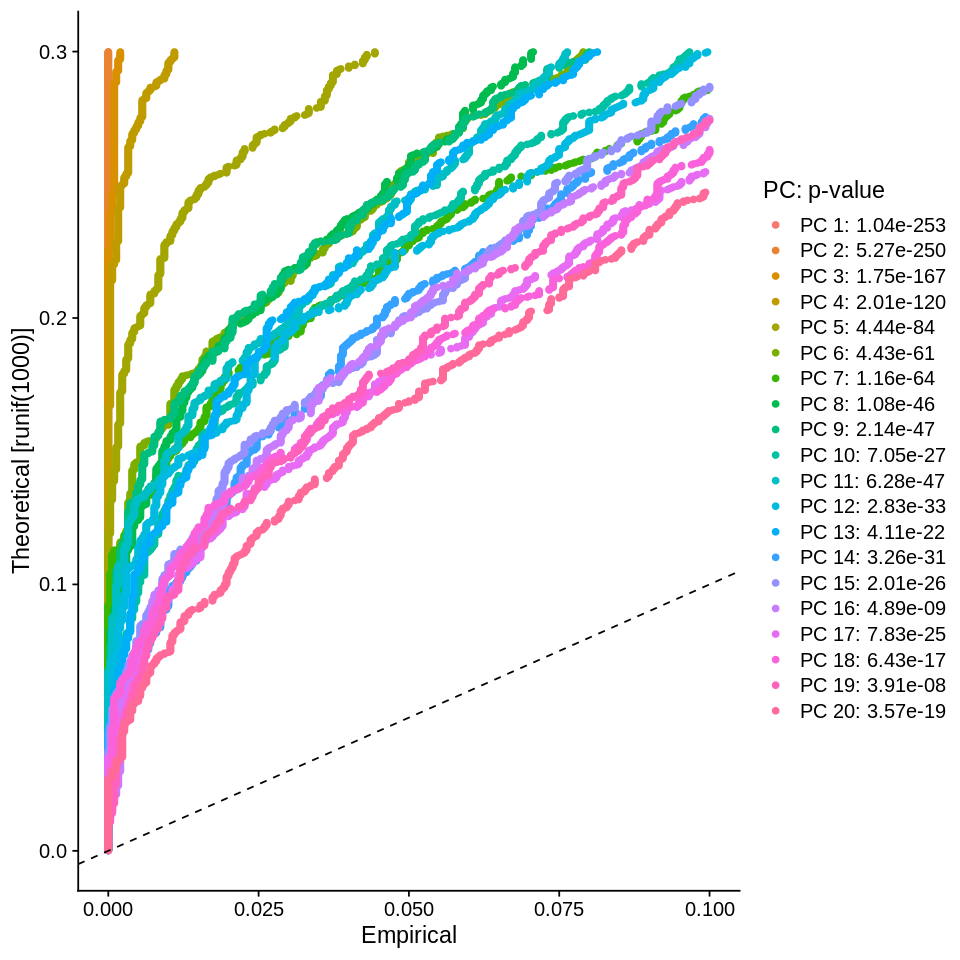

In [34]:
JackStrawPlot(normal2, dims = 1:20)

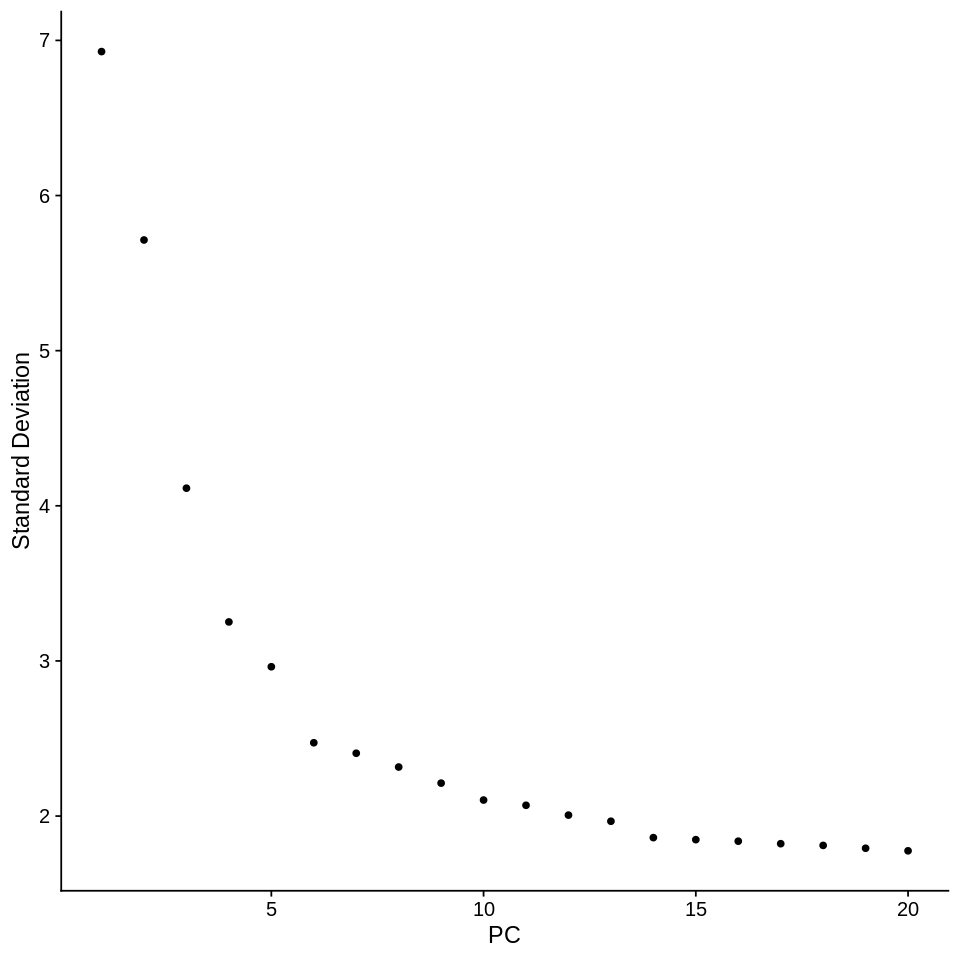

In [35]:
ElbowPlot(normal2)

In [61]:
normal2 <- FindNeighbors(normal2, dims = 1:15)
normal2 <- FindClusters(normal2, resolution = 1)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4722
Number of edges: 160852

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7660
Number of communities: 14
Elapsed time: 0 seconds


In [62]:
normal2 <- RunUMAP(normal2, dims = 1:15)

13:02:03 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

13:02:03 Read 4722 rows and found 15 numeric columns

13:02:03 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

13:02:03 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:02:03 Writing NN index file to temp file /tmp/RtmpYXGwus/file826da375fb1fa

13:02:03 Searching Annoy index using 1 thread, search_k = 3000

13:02:04 Annoy recall = 100%

13:02:05 Commencing smooth kNN distance calibration using 1 thread

13:02:06 Initializing from normalized Laplacian + noise

13:02:06 Commencing opt

In [64]:
options(repr.plot.height=8,repr.plot.width=8)

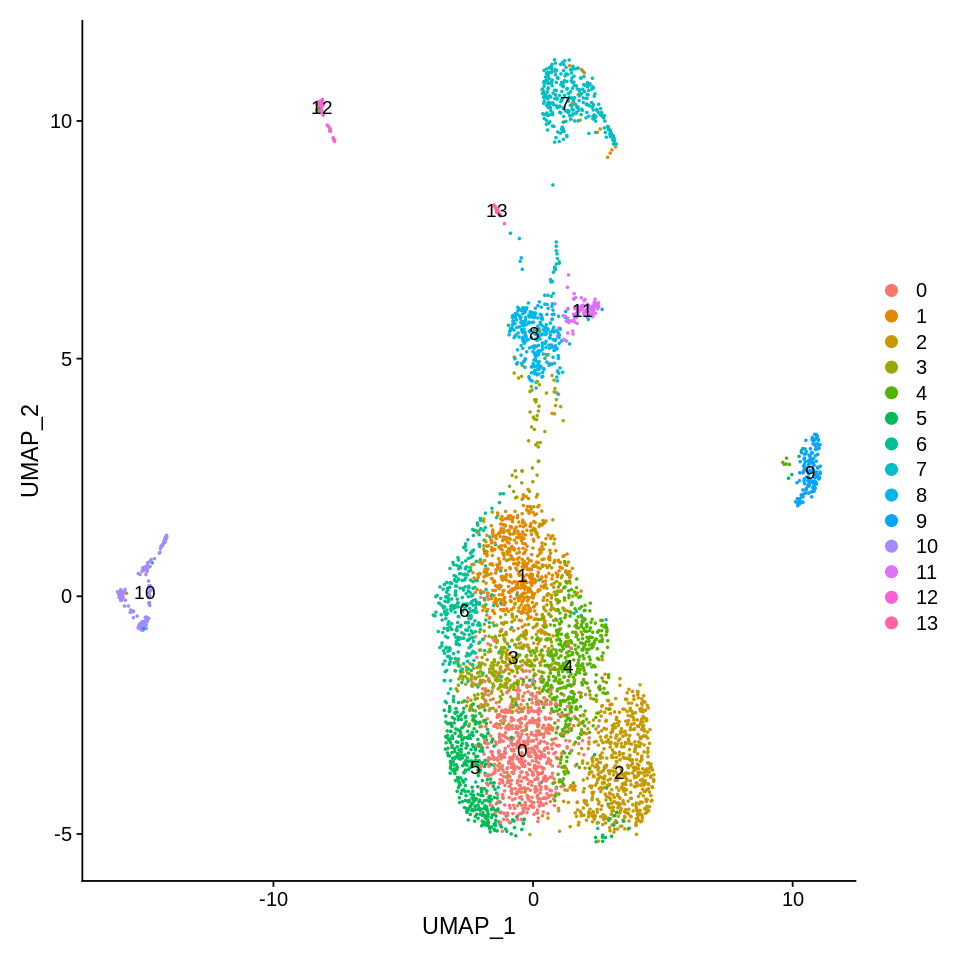

In [65]:
DimPlot(normal2, reduction = "umap",label=T)

In [42]:
options(repr.plot.height=9,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



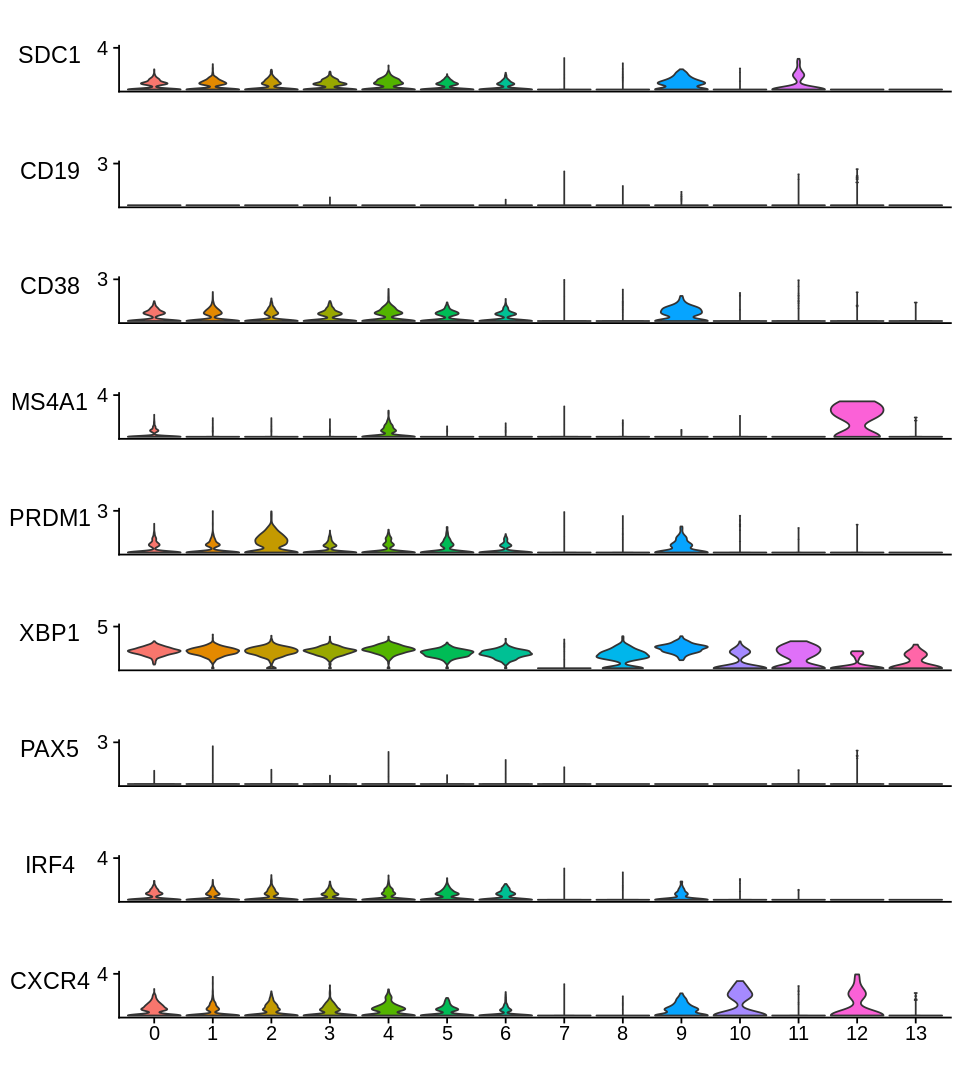

In [43]:
features<- c("SDC1","CD19","CD38","MS4A1","PRDM1","XBP1","PAX5","IRF4","CXCR4")
StackedVlnPlot(obj =normal2, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



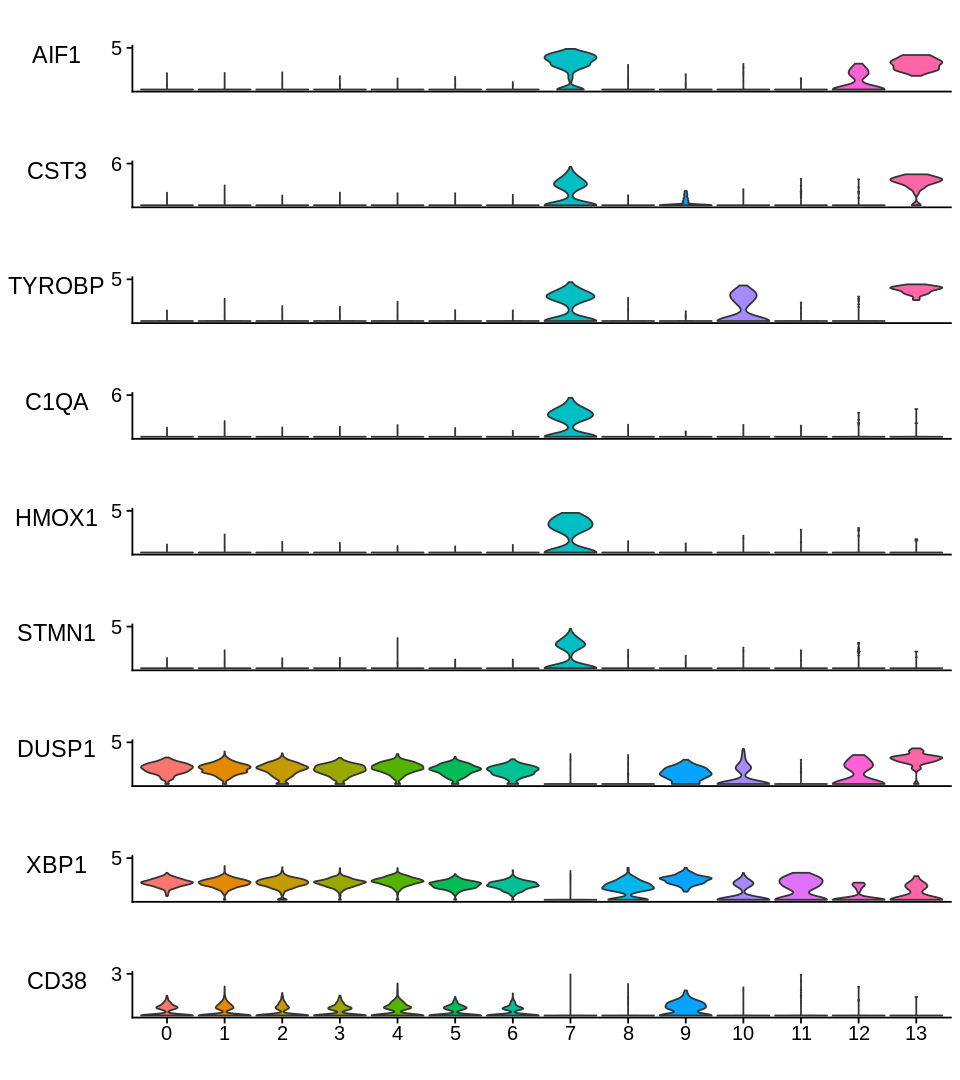

In [44]:
features<- c("AIF1","CST3","TYROBP","C1QA","HMOX1","STMN1","DUSP1","XBP1","CD38")
StackedVlnPlot(obj =normal2, features = features)

In [45]:
options(repr.plot.height=6,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



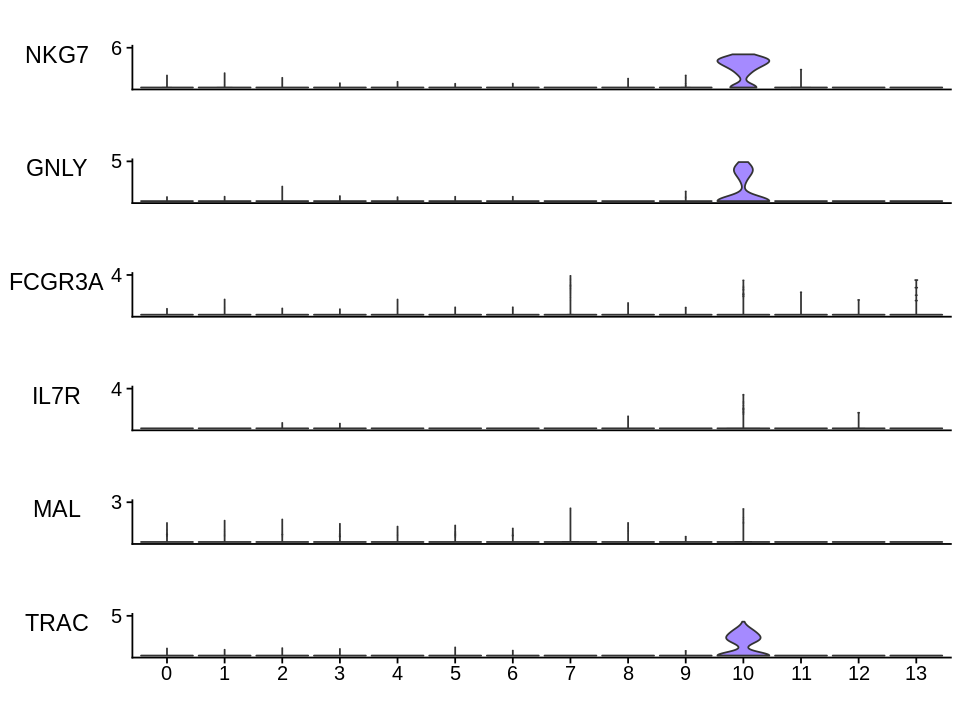

In [46]:
features<- c("NKG7","GNLY","FCGR3A","IL7R","MAL","TRAC")
StackedVlnPlot(obj =normal2, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



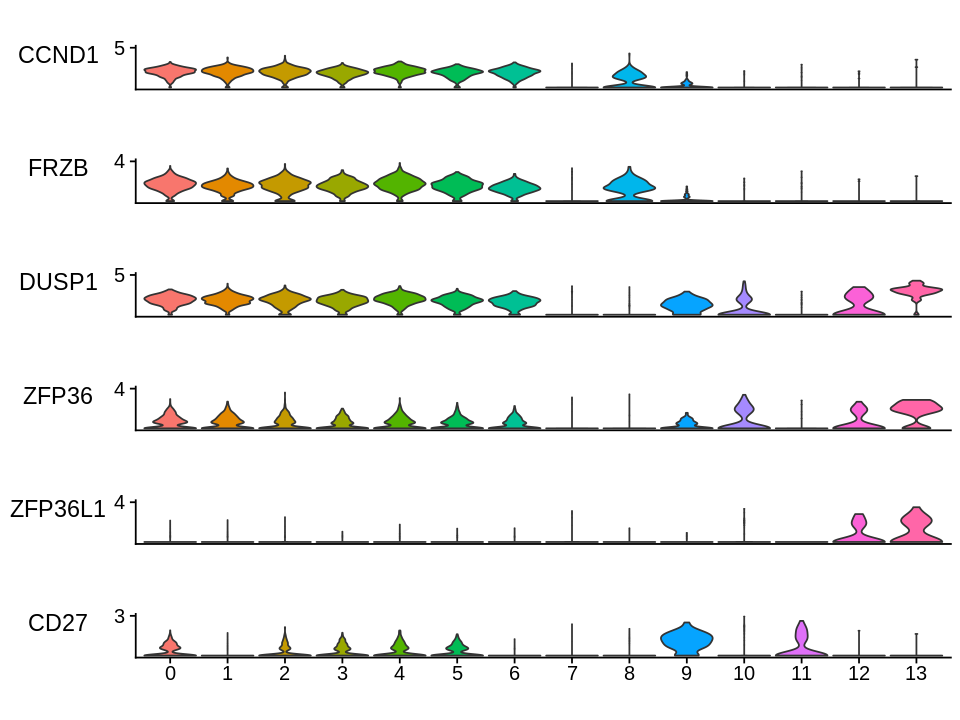

In [47]:
features<- c("CCND1","FRZB","DUSP1","ZFP36","ZFP36L1","CD27")
StackedVlnPlot(obj =normal2, features = features)

In [48]:
options(repr.plot.height=4,repr.plot.width=8)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




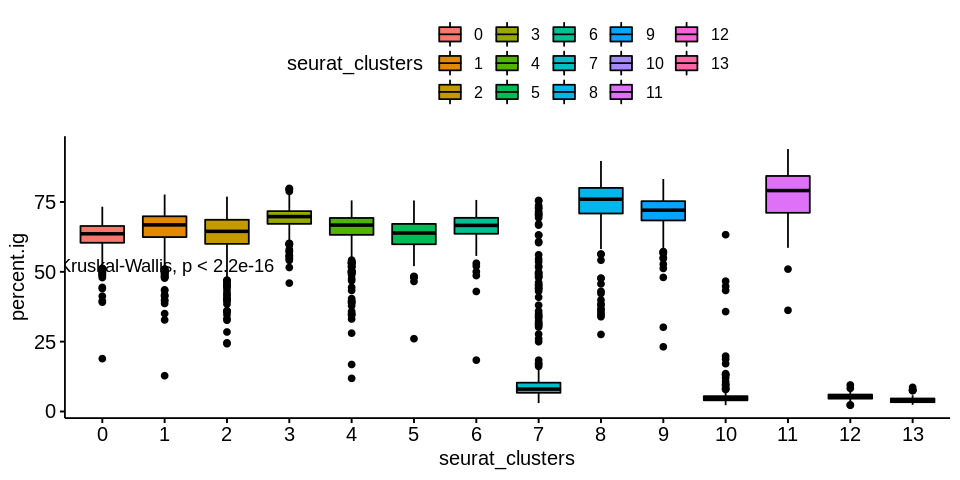

In [49]:
library(ggpubr)
library(RColorBrewer)
ggboxplot(normal2@meta.data, x="seurat_clusters", y="percent.ig", fill = "seurat_clusters")+
  stat_compare_means(label.y = 50)

In [50]:
normal3.markers <- FindAllMarkers(normal2, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
normal3.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.578038e-49,0.4503243,0.729,0.435,2.468051e-45,0,RNGTT
9.497436e-38,0.3877223,0.713,0.449,1.485399e-33,0,PMAIP1
8.111931e-36,0.4736076,0.960,0.783,1.268706e-31,0,JUN
8.030663e-34,0.4114185,0.964,0.773,1.255996e-29,0,FRZB
1.052595e-31,0.3618929,0.991,0.783,1.646259e-27,0,CCND1
1.180260e-124,1.2068518,0.919,0.571,1.845926e-120,1,FOS
1.938340e-94,0.8389111,0.745,0.376,3.031563e-90,1,EGR1
9.932239e-54,0.9068513,0.830,0.573,1.553402e-49,1,IER2
3.136736e-50,0.7012017,0.869,0.612,4.905855e-46,1,JUNB


In [51]:
options(repr.plot.height=10,repr.plot.width=10)

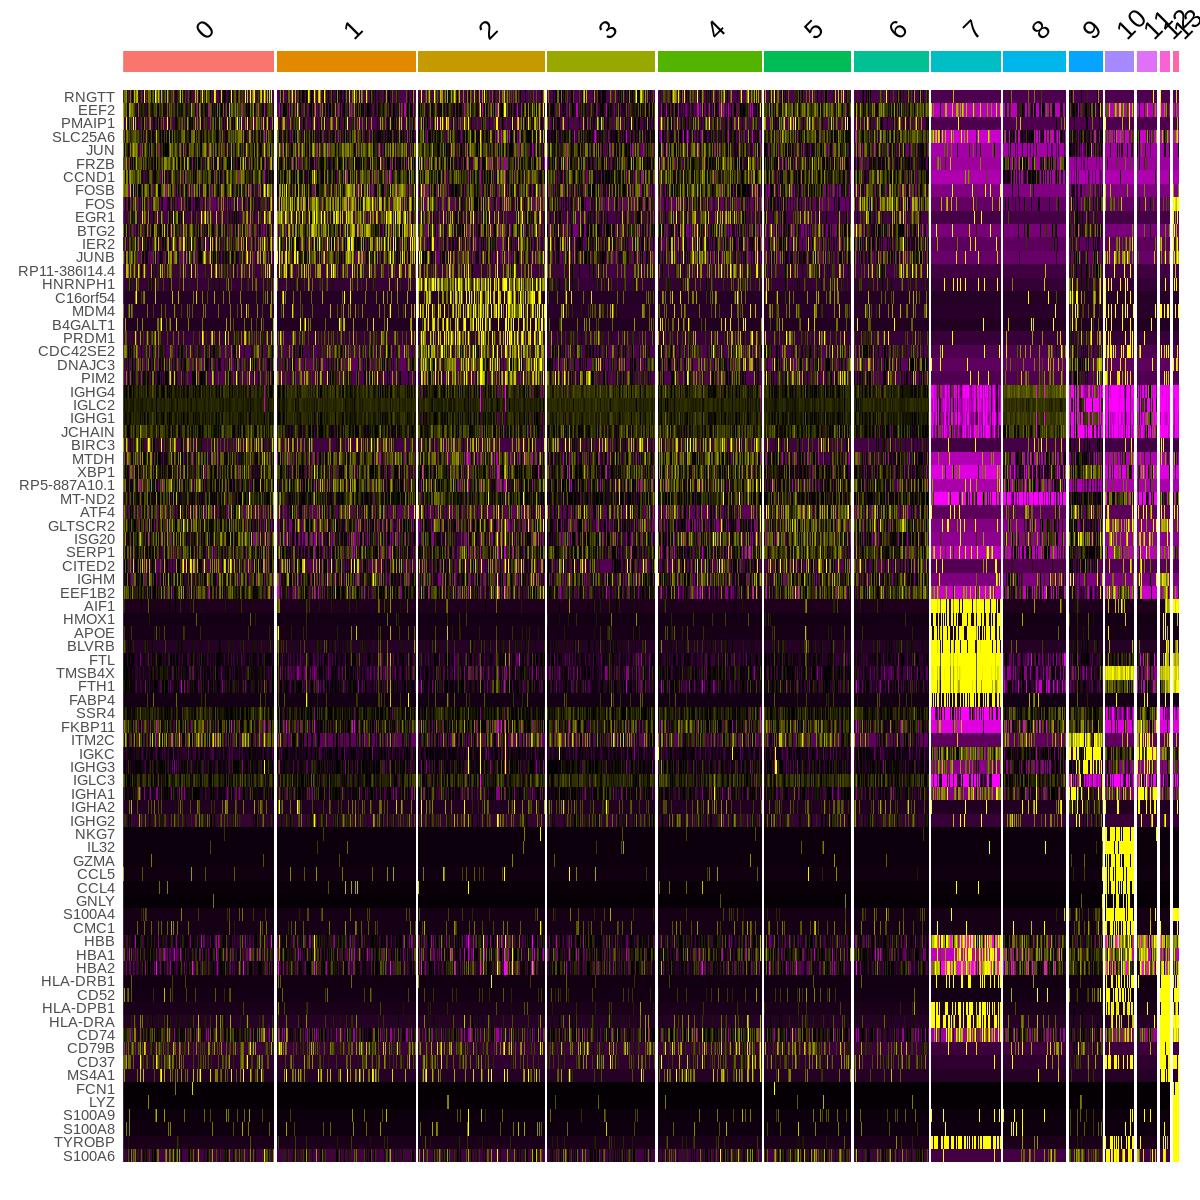

In [52]:
top10 <- normal3.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
DoHeatmap(normal2, features = top10$gene) + NoLegend()

In [53]:
library("Seurat")
library("SingleR")

In [54]:
counts<-normal2@assays$RNA@counts
clusters<-normal2@meta.data$seurat_clusters
ann=normal2@meta.data$orig.ident

In [55]:
singler = CreateSinglerObject(counts, annot = ann, "normal",
  species = "Human", citation = "",
  ref.list = list(), variable.genes = "de",
  fine.tune = F, do.signatures = T, clusters = clusters, do.main.types = T,
  reduce.file.size = T, numCores = 1)

[1] "Dimensions of counts data: 15640x4722"
[1] "Annotating data with HPCA..."
[1] "Variable genes method: de"
[1] "Number of DE genes:3137"
[1] "Number of cells: 4722"
[1] "Number of DE genes:3137"
[1] "Number of clusters: 14"
[1] "Annotating data with HPCA (Main types)..."
[1] "Number of DE genes:2431"
[1] "Number of cells: 4722"
[1] "Number of DE genes:2431"
[1] "Number of clusters: 14"
[1] "Annotating data with Blueprint_Encode..."
[1] "Variable genes method: de"
[1] "Number of DE genes:2996"
[1] "Number of cells: 4722"
[1] "Number of DE genes:2996"
[1] "Number of clusters: 14"
[1] "Annotating data with Blueprint_Encode (Main types)..."
[1] "Number of DE genes:2481"
[1] "Number of cells: 4722"
[1] "Number of DE genes:2481"
[1] "Number of clusters: 14"


In [56]:
singler$seurat = normal
singler$meta.data$xy = normal2@reductions$umap@cell.embeddings
clusterAnn=singler$singler[[2]]$SingleR.clusters.main$labels
clusterAnn

0,B-cells
1,B-cells
2,B-cells
3,B-cells
4,B-cells
5,B-cells
6,B-cells
7,Macrophages
8,B-cells
9,B-cells
10,CD8+ T-cells


In [57]:
clusterAnn<-as.data.frame(clusterAnn)
clusterAnn

,V1
,<chr>
0,B-cells
1,B-cells
2,B-cells
3,B-cells
4,B-cells
5,B-cells
6,B-cells
7,Macrophages
8,B-cells


In [58]:
type<-as.data.frame(singler$other)
type

,singler$other
,<chr>
AAACCTGAGCTCTCGG-1,B cells
AAACCTGAGGGCACTA-1,B cells
AAACCTGAGTAATCCC-1,CD4 T cells
AAACCTGAGTAGATGT-1,CD4 T cells
AAACCTGCACTAGTAC-1,B cells
AAACCTGCATCCGTGG-1,B cells
AAACCTGGTCGAACAG-1,FCGR3A+ Monocytes
AAACCTGTCAACCAAC-1,B cells
AAACCTGTCCCACTTG-1,B cells


In [59]:
count<-table(type)
count

type
          B cells   CD14+ Monocytes       CD4 T cells       CD8 T cells 
             2624               277              1137                66 
  Dendritic cells FCGR3A+ Monocytes    Megakaryocytes          NK cells 
              127               300                73               118 

In [60]:
names<-as.vector(rownames(normal2@meta.data))
type2<-type[names,]

In [66]:
plasma<-subset(normal2,ident=c(0,1,2,3,4,5,6,8,9,11))

In [67]:
options(repr.plot.height=8,repr.plot.width=8)

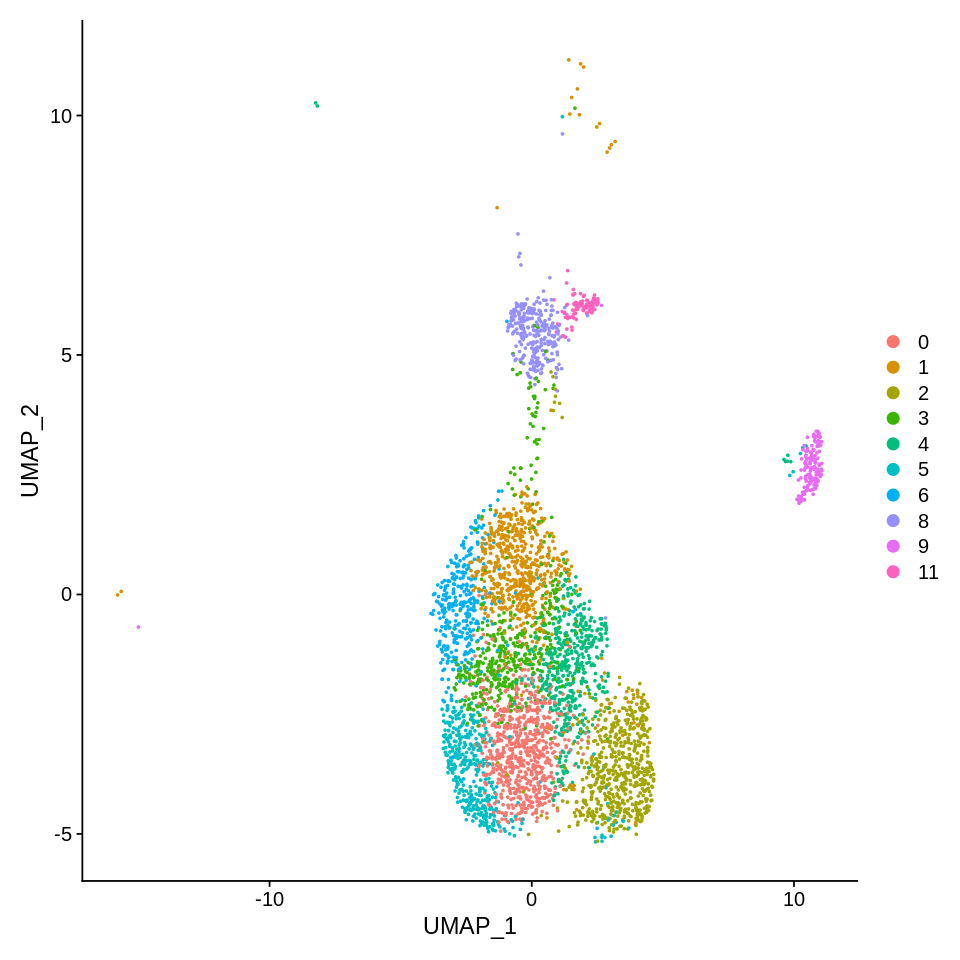

In [68]:
DimPlot(plasma, reduction = "umap")

In [69]:
plasma.markers <- FindAllMarkers(plasma, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
plasma.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 8

Calculating cluster 9

Calculating cluster 11



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.789577e-69,0.3814133,1.000,0.991,2.798899e-65,0,EEF1A1
1.192486e-42,0.3550997,0.947,0.778,1.865049e-38,0,GLTSCR2
8.040762e-40,0.3513687,0.990,0.904,1.257575e-35,0,EEF2
2.008054e-35,0.3173828,0.993,0.922,3.140597e-31,0,SLC25A6
5.297043e-35,0.4161428,0.925,0.762,8.284575e-31,0,BTG1
7.707588e-35,0.3139494,0.997,0.926,1.205467e-30,0,RPS2
1.885642e-32,0.3737407,0.729,0.497,2.949144e-28,0,RNGTT
3.885626e-24,0.3157799,0.928,0.769,6.077119e-20,0,CTSW
4.762236e-24,0.3322409,0.713,0.509,7.448136e-20,0,PMAIP1


In [70]:
options(repr.plot.height=8,repr.plot.width=8)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



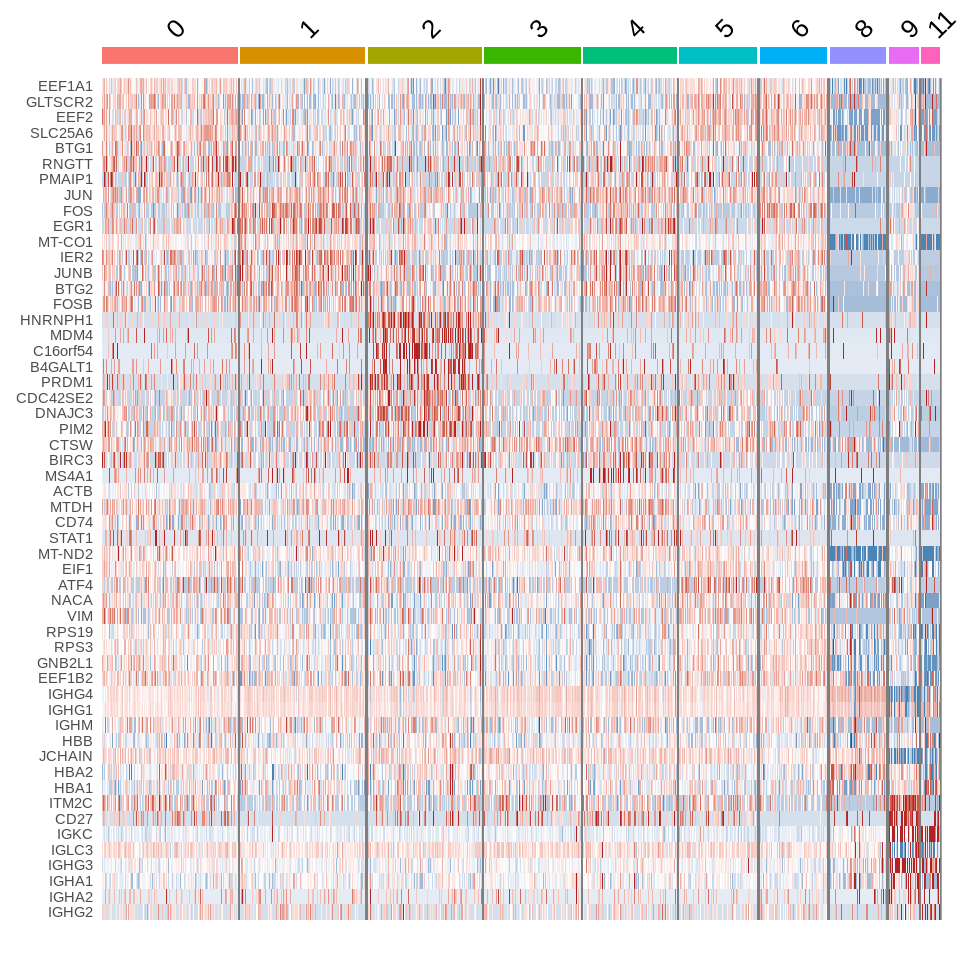

In [71]:
top10 <- plasma.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
DoHeatmap(plasma, features = top10$gene) + NoLegend()+ scale_fill_gradientn(colors = c("steelblue", "white", "firebrick"))

In [72]:
save(plasma,file="0709-pALPC3-plasma.Rda")

In [73]:
plasma

An object of class Seurat 
15640 features across 4190 samples within 1 assay 
Active assay: RNA (15640 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

In [74]:
options(repr.plot.height=9,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



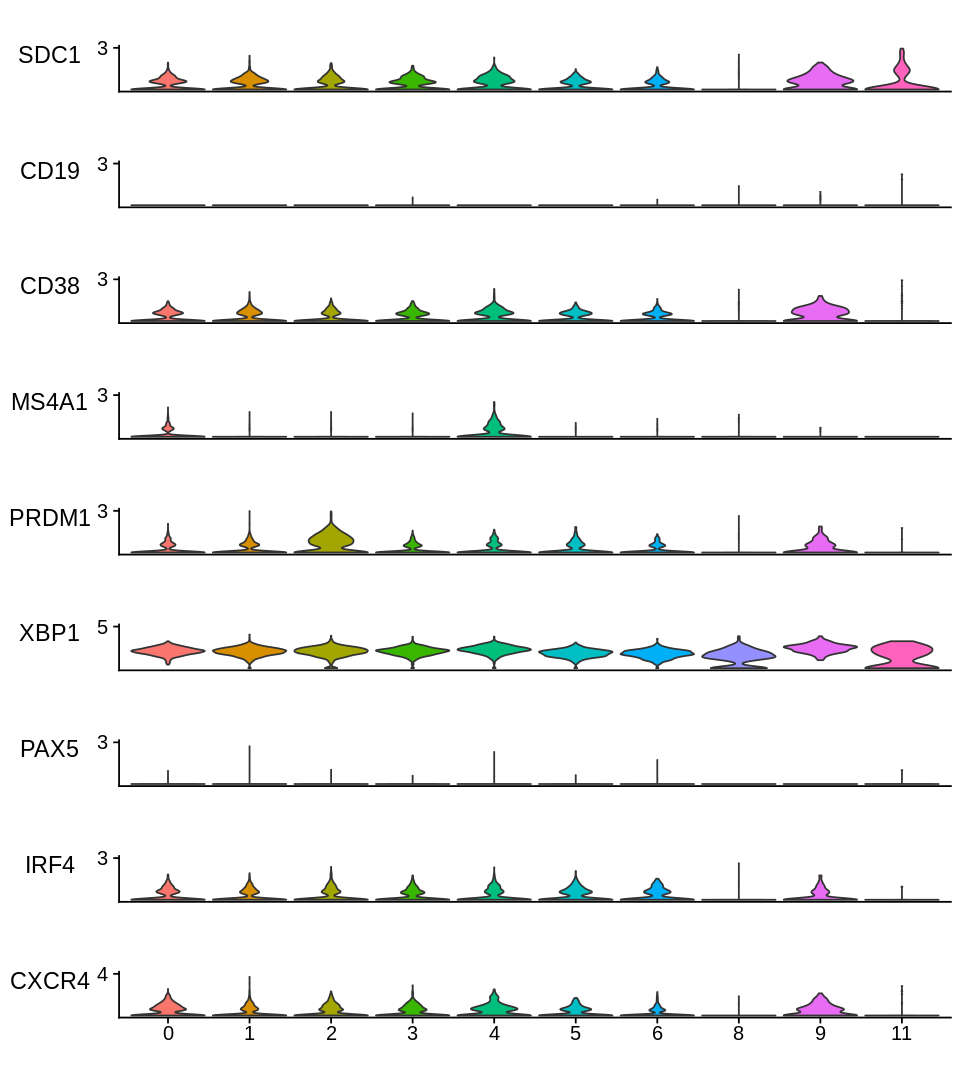

In [75]:
features<- c("SDC1","CD19","CD38","MS4A1","PRDM1","XBP1","PAX5","IRF4","CXCR4")
StackedVlnPlot(obj =plasma, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



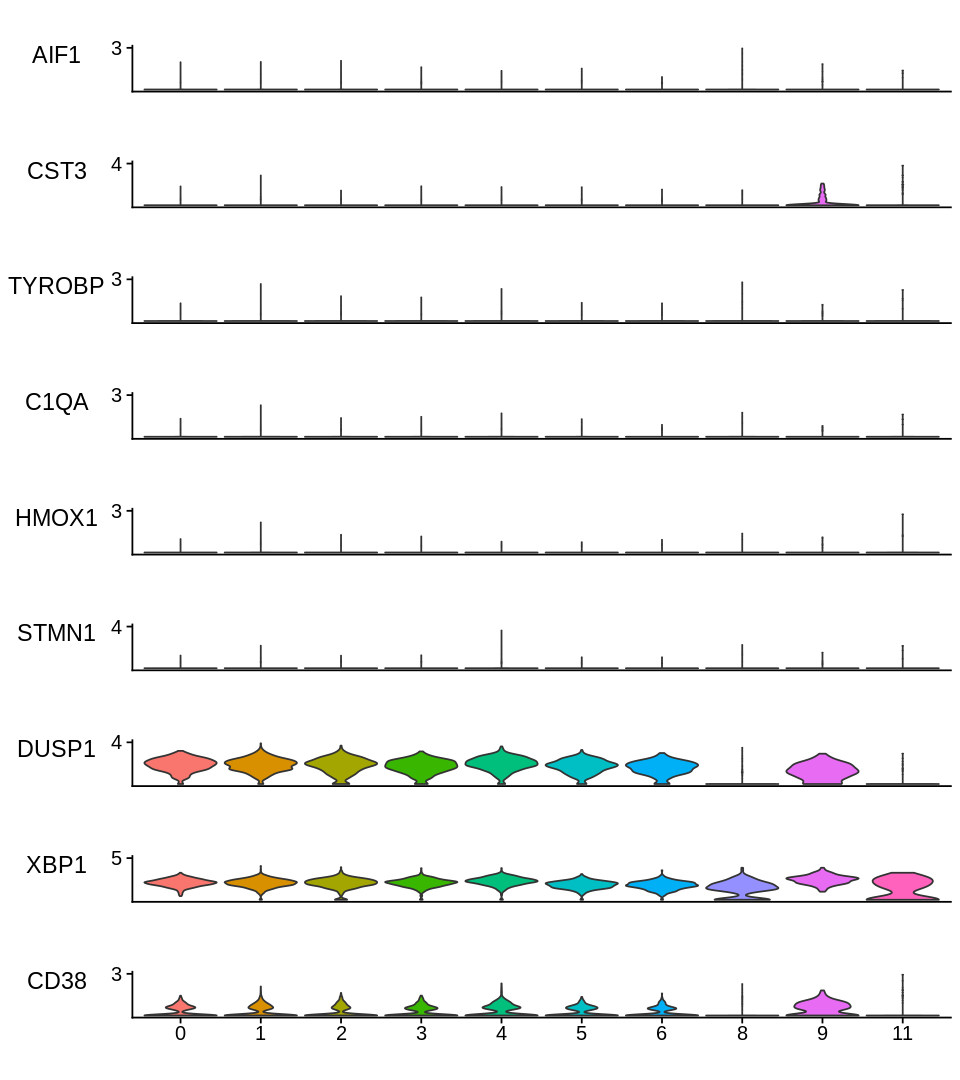

In [76]:
features<- c("AIF1","CST3","TYROBP","C1QA","HMOX1","STMN1","DUSP1","XBP1","CD38")
StackedVlnPlot(obj =plasma, features = features)

In [77]:
options(repr.plot.height=6,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



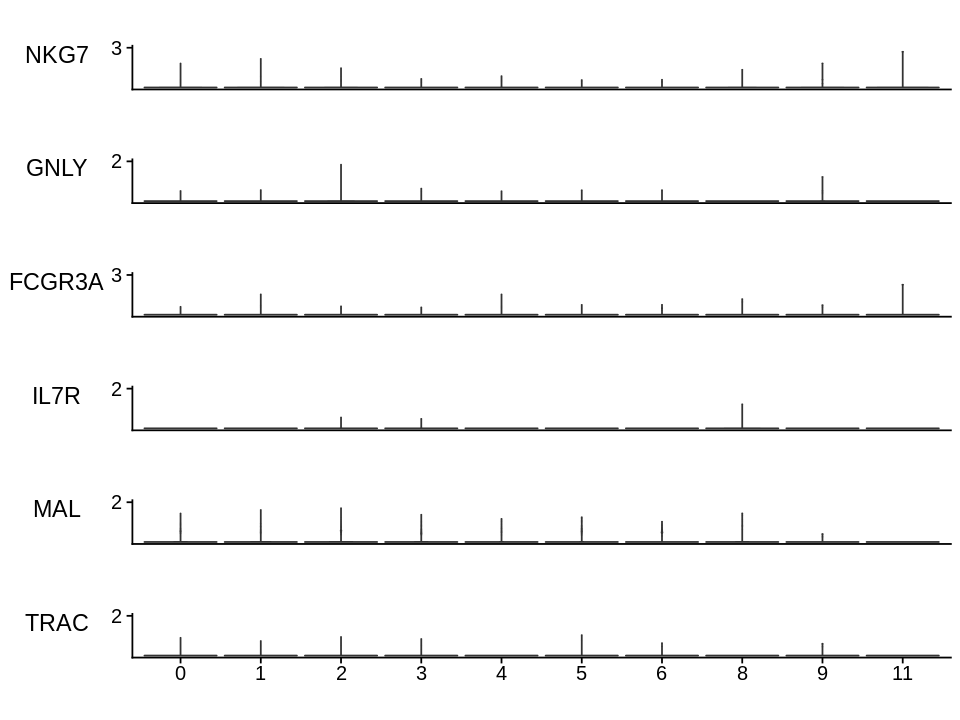

In [78]:
features<- c("NKG7","GNLY","FCGR3A","IL7R","MAL","TRAC")
StackedVlnPlot(obj =plasma, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



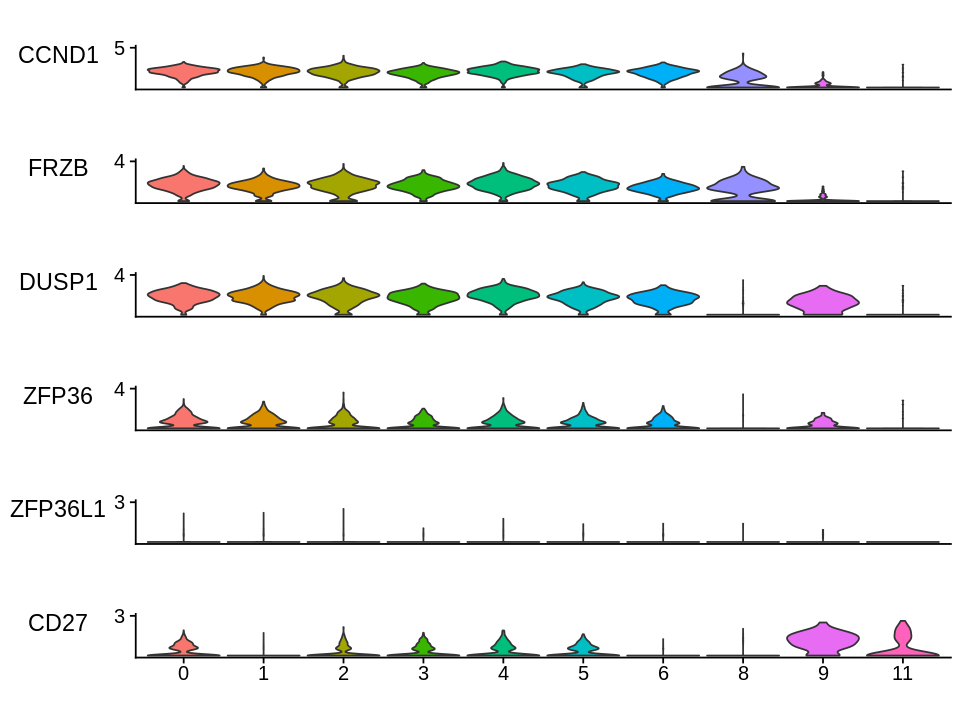

In [79]:
features<- c("CCND1","FRZB","DUSP1","ZFP36","ZFP36L1","CD27")
StackedVlnPlot(obj =plasma, features = features)